In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from src import utils
from src.data import make_dataset
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [2]:
MODEL_BASEDIR = os.path.join(utils.get_project_root(), 'models')
model_names = ['logistic_regression_model', 'poisson_binomial_model', 'mixture', 'log_advstat_l2', 'log_alladvstat_l1', 'boxScoresLogisticRegression', 'knn20']
model_names = ['logistic_regression_model', 'poisson_binomial_model', 'mixture']
model_names

['logistic_regression_model', 'poisson_binomial_model', 'mixture']

In [3]:
years = list(range(2003, 2020))
n_years = len(years)
n_train_years = int(len(years) * 0.5)
train_years = np.random.choice(years, n_train_years, replace=False)
train_years
test_years = [y for y in years if y not in train_years]

# Load Model Predictions

In [4]:
# keep a dataframe of predictions for each year
prediction_by_year = {}
for year in years:
    data = make_dataset.get_train_data_v1(year)
    prediction = pd.DataFrame()
    prediction['team1win'] = data[data['tourney'] == 1].set_index('ID')['team1win']
    for model_name in model_names:
        pred_fname = os.path.join(MODEL_BASEDIR, model_name, str(year), 'pred.csv')
        if os.path.exists(pred_fname):
            prediction[model_name] = pd.read_csv(pred_fname).set_index('ID')['Pred']
    prediction_by_year[year] = prediction

/home/ubuntu/kaggle-march-madness-men-2019/src/data/make_dataset.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  NCAATourneyResults = pd.concat([NCAATourneyResults, tourney2019])
/home/ubuntu/kaggle-march-madness-men-2019/src/data/make_dataset.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([RegularSeasonResults, NCAATourneyResults])


In [5]:
class_by_year = {}
for year in years:
    prediction = prediction_by_year[year]
    class_by_year[year] = (prediction.drop('team1win', axis=1) > 0.5).astype(int)

# Post-Process and Ensemble Predictions

In [6]:
threshold = 0.8  # for logistic model confidence
finangle_param = 0.15
correct_by_year = {}
for year in years:
    prediction = prediction_by_year[year]
    pred_class = class_by_year[year]
    prediction['ensemble_mean'] = prediction[model_names].mean(axis=1)
    prediction['ensemble_vote'] = (prediction[model_names] >= 0.5).mean(axis=1)
    logistic_confidence = (prediction['logistic_regression_model'] - 0.5).abs() + 0.5
    logistic_prediction = prediction['logistic_regression_model']
    is_confident = logistic_confidence >= threshold
    # ensemble only when logistic regression is not sure
    prediction['ensemble_vote_middle'] = np.where(logistic_confidence > threshold, 
                                                  prediction['logistic_regression_model'], 
                                                  prediction['ensemble_vote'])
    prediction['ensemble_mean_middle'] = np.where(logistic_confidence > threshold, 
                                                  prediction['logistic_regression_model'], 
                                                  prediction['ensemble_mean'])
    prediction['ensemble_first3'] = np.where(pred_class['logistic_regression_model'] != pred_class['poisson_binomial_model'],
                                             prediction['mixture'],
                                             prediction['logistic_regression_model'])
    # finangling with not confident predictions
    prediction['finangle'] = logistic_prediction.where(
        is_confident,
        np.ones(prediction.shape[0]) * 0.5 + finangle_param)
    prediction['finangle_opposite'] = logistic_prediction.where(
        is_confident,
        np.ones(prediction.shape[0]) * 0.5 - finangle_param)


# Visualize Correct Predictions

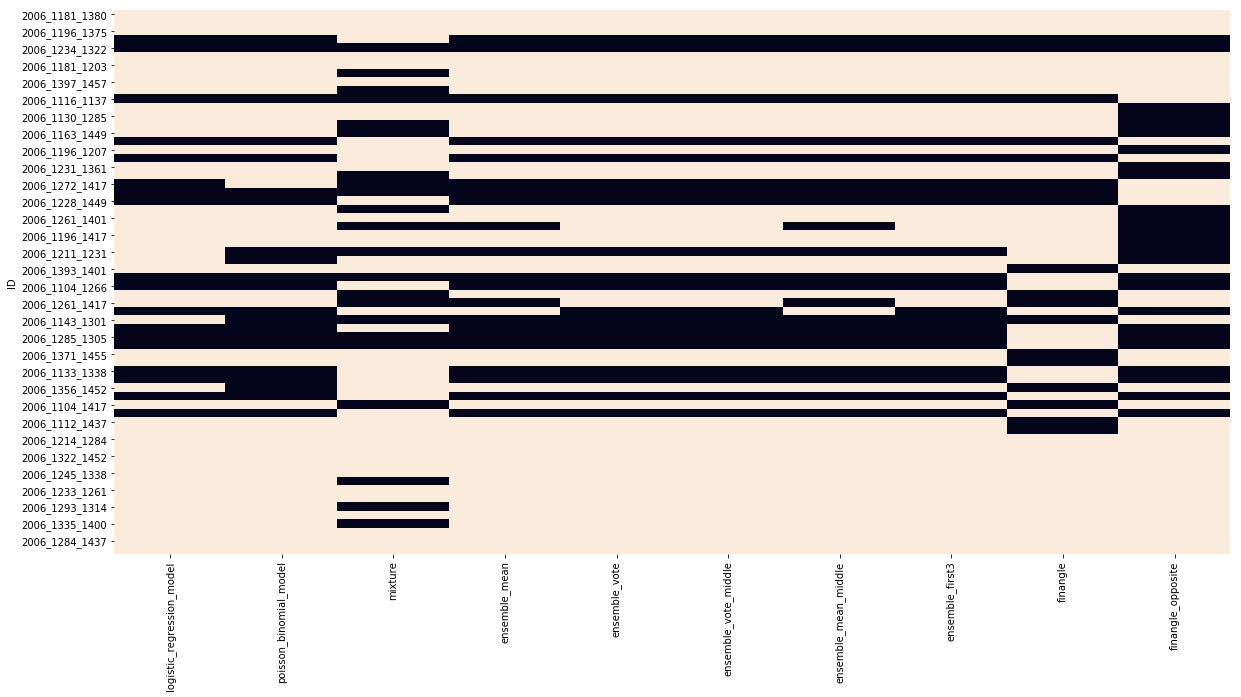

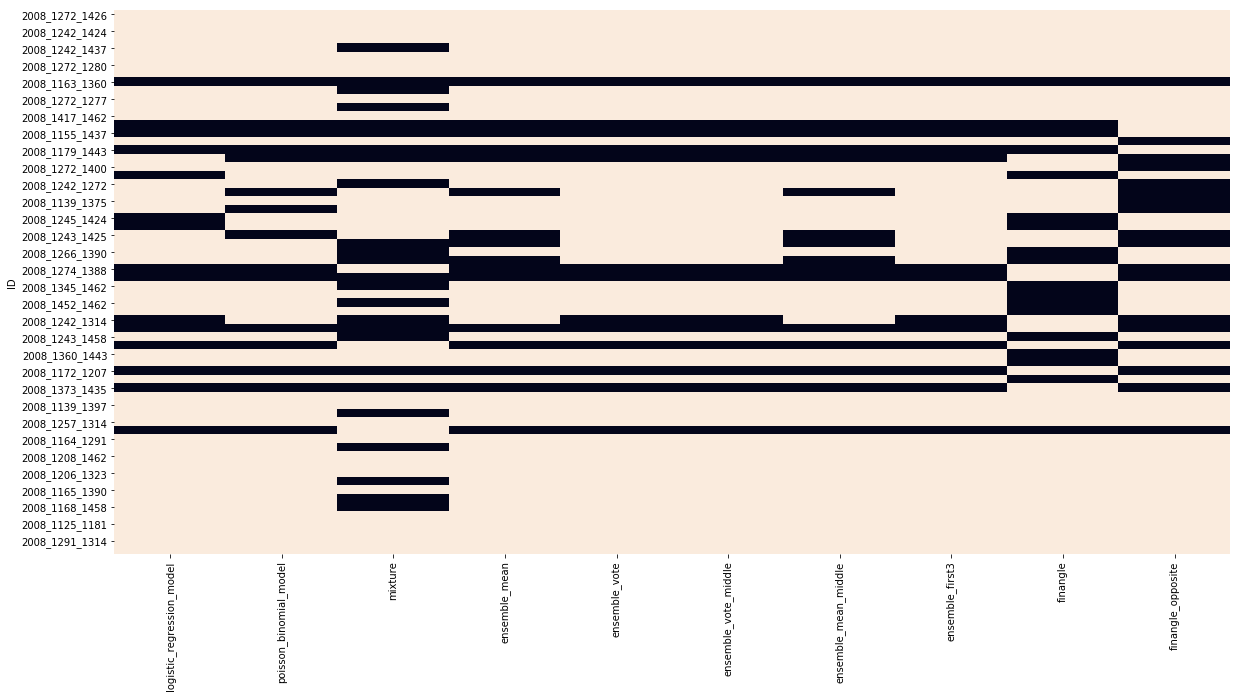

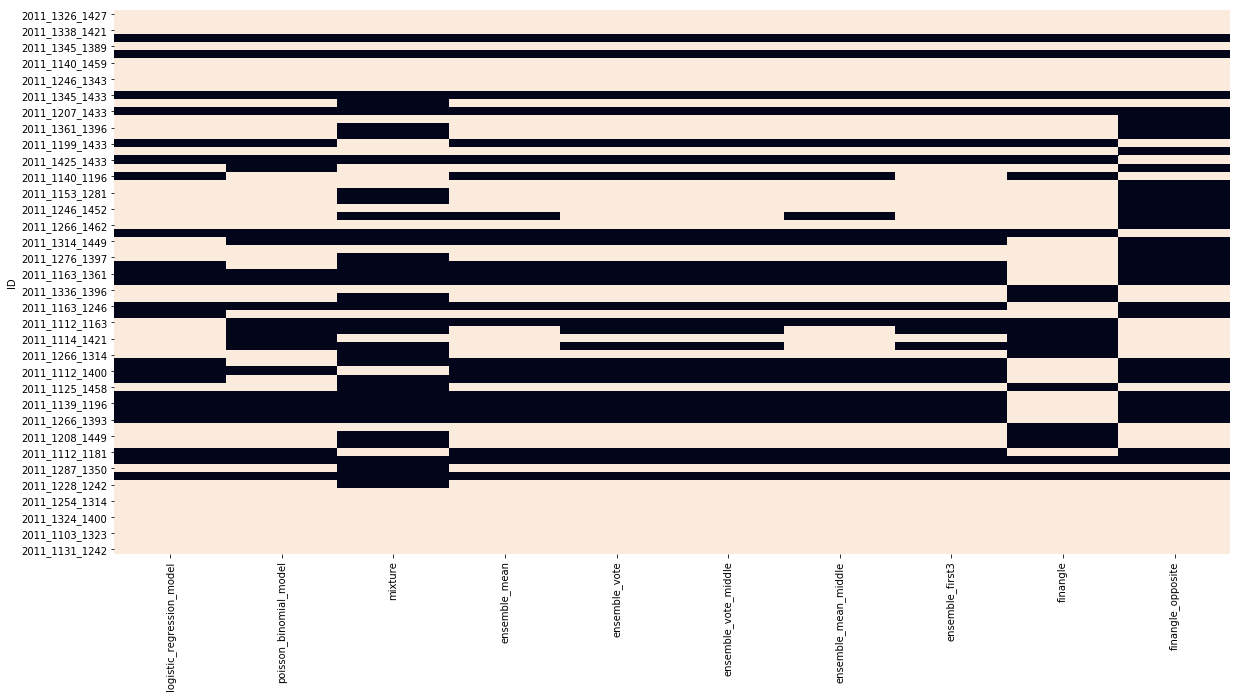

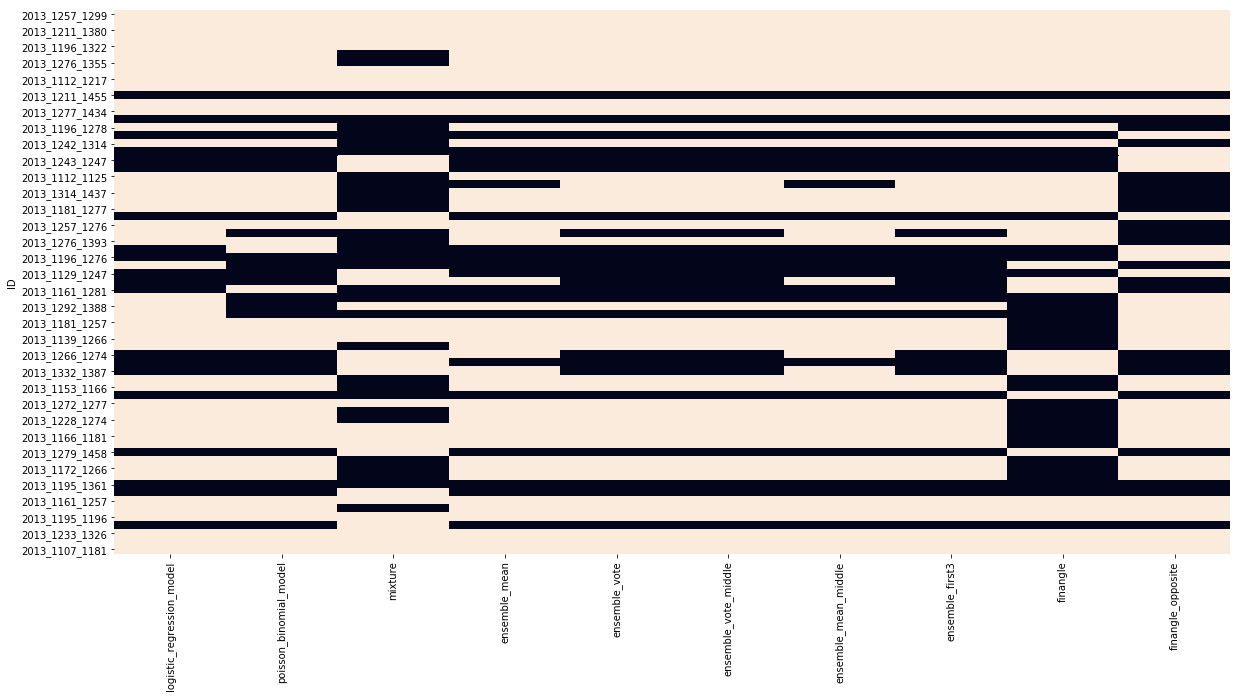

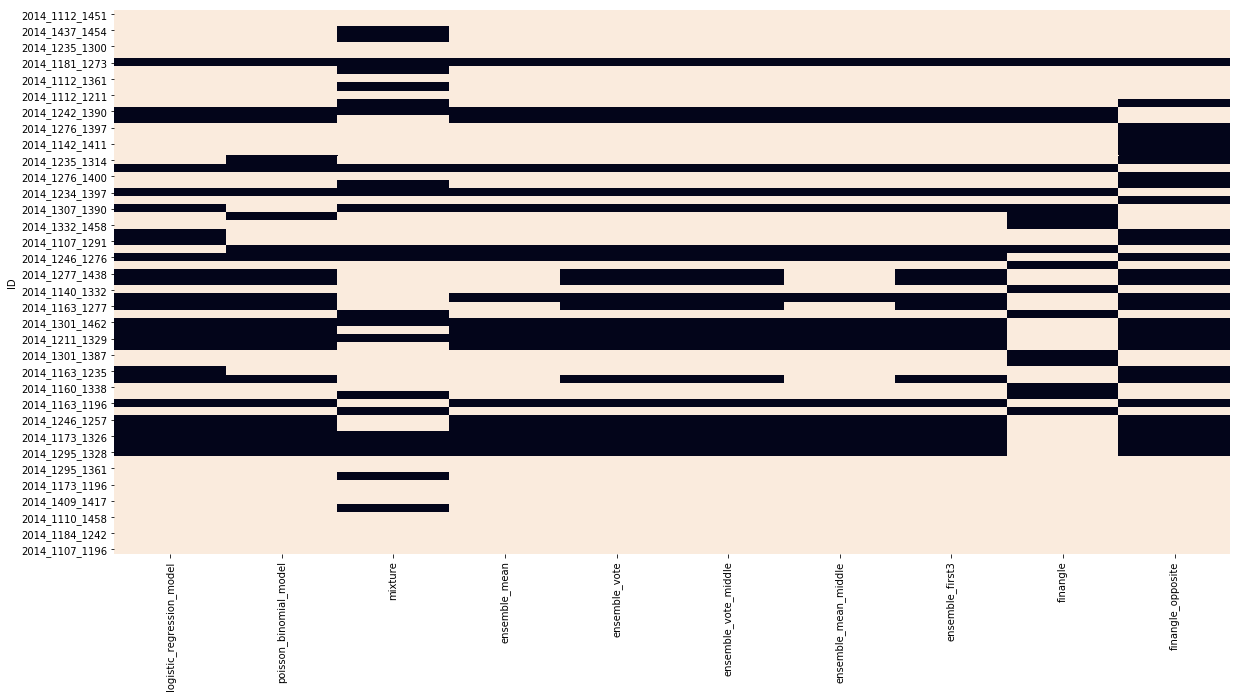

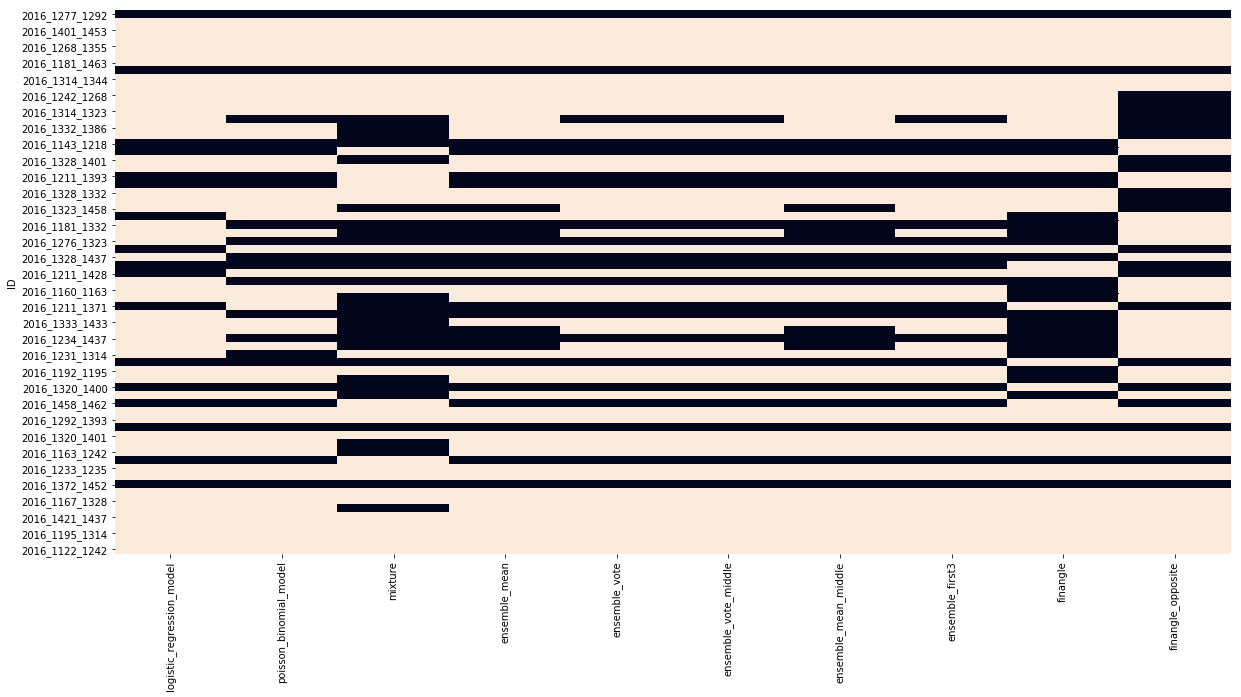

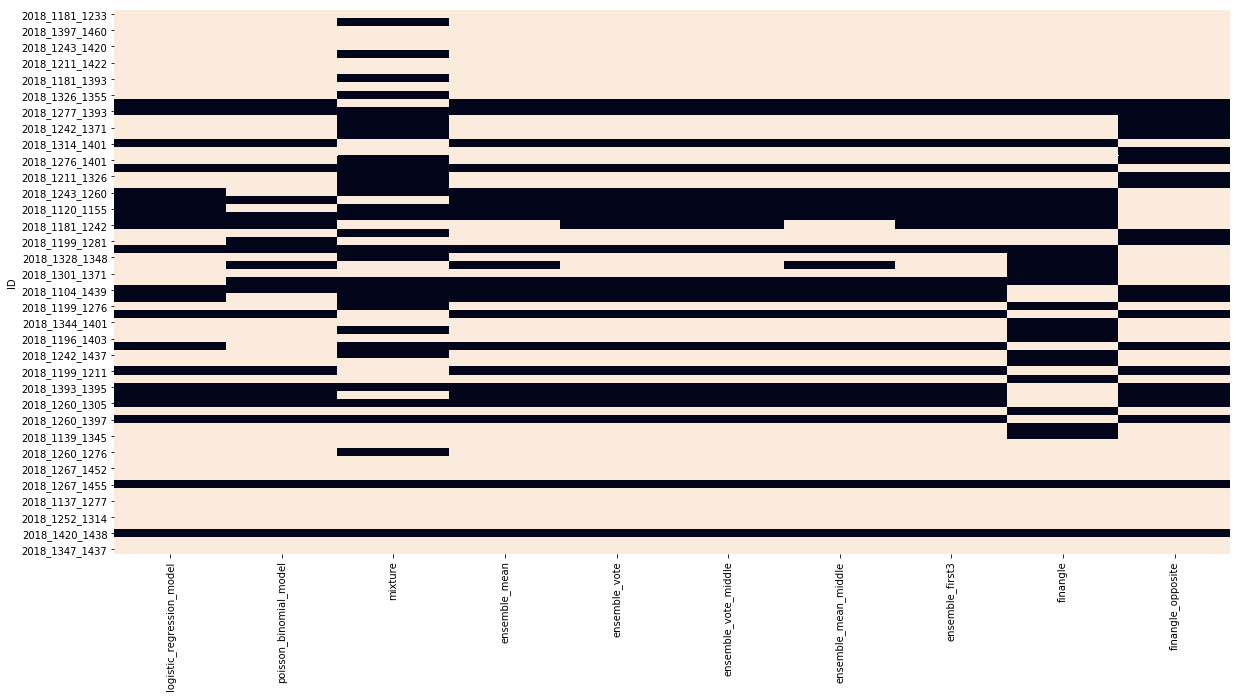

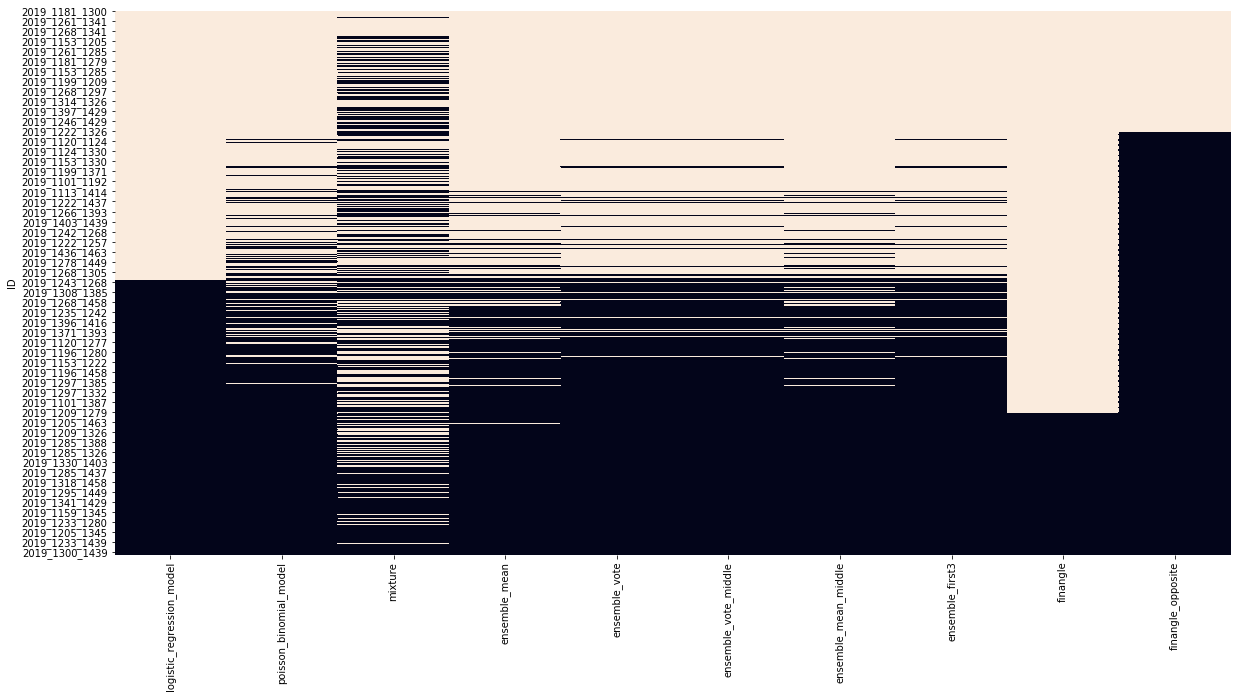

In [7]:
correct_by_year = {}
for year in years:
    prediction = prediction_by_year[year]
    correct_by_year[year] = (prediction.drop('team1win', axis=1) > 0.5).eq(prediction['team1win'], axis='index')
    if year in train_years:
        fig, ax = plt.subplots(figsize=(20, 10))
        idx_ordered = prediction['logistic_regression_model'].sort_values(ascending=False).index
        sns.heatmap(correct_by_year[year].loc[idx_ordered], ax=ax, cbar=False)
        plt.show()

In [8]:
logloss_by_year = {}
for year in years:
    prediction = prediction_by_year[year]
    logloss_by_year[year] = - (np.log(prediction.drop('team1win', axis=1)).multiply(prediction['team1win'], axis='index') + np.log(1-prediction.drop('team1win', axis=1)).multiply(1-prediction['team1win'], axis='index'))
# np.log(1-prediction.drop('team1win', axis=1))

/home/ubuntu/kaggle-march-madness-men-2019/venv/march_madness/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


# Accuracy Curve when Logistic Regression is not Confident

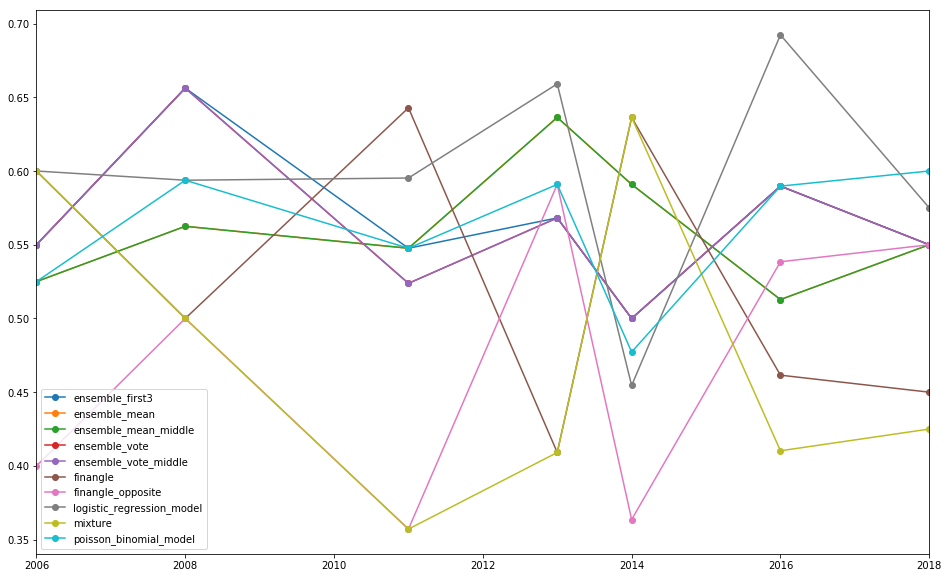

In [12]:
# accuracy curve
train = True

drop_cols = [# 'ensemble_vote', 'ensemble_mean', 'mixture', 
             # 'log_advstat_l2', 'log_alladvstat_l1',
             # 'ensemble_mean', 'ensemble_mean_middle',
             # 'ensemble_vote_middle', 
             # 'knn20', # 'boxScoresLogisticRegression',
             # 'ensemble_vote_few', 'ensemble_vote_few_middle',
             # 'ensemble_mean_few'
            ]
    

accuracies = {}
for year in train_years if train else years:
    if year != 2019:
        prediction = prediction_by_year[year]
        logistic_confidence = (prediction['logistic_regression_model'] - 0.5).abs() + 0.5
        idx_middle = logistic_confidence <= threshold
        accuracies[year] = {c:(prediction.loc[idx_middle, 'team1win'] == 
                               (prediction.loc[idx_middle, c] >= 0.5)).mean() 
                            for c in prediction.columns if c != 'team1win'}
df_accuracy = pd.DataFrame(accuracies).transpose().sort_index()
fig, ax = plt.subplots(figsize = (16, 10))
df_accuracy.drop(drop_cols, axis=1).plot(marker='o', legend=True, ax=ax)
plt.show()

# Log-loss Curve

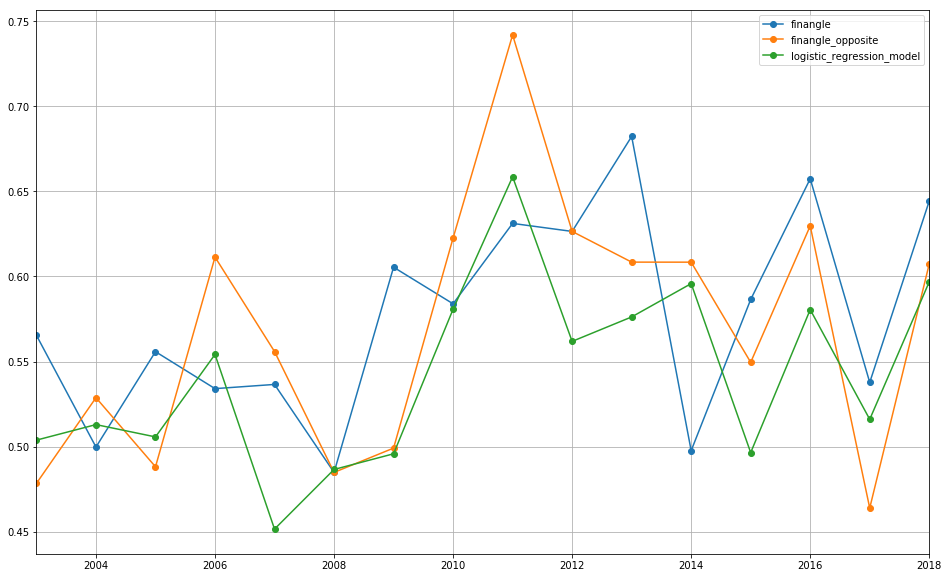

In [10]:
# loss curve
train = False

# predictions to drop from plot
drop_cols = ['ensemble_vote', 'ensemble_mean', 'mixture', 
             'log_advstat_l2', 'log_alladvstat_l1',
             'ensemble_vote_middle', 'knn20', 'boxScoresLogisticRegression',
             'ensemble_first3', 'ensemble_mean_middle', 'poisson_binomial_model',
            ]
drop_cols = ['ensemble_vote', 'ensemble_vote_middle', 'mixture', 'ensemble_mean_middle',
            'ensemble_mean', 'poisson_binomial_model', 'ensemble_first3']

losses = {}
for year in train_years if train else years:
    if year != 2019:
        prediction = prediction_by_year[year]
        losses[year] = {c:log_loss(prediction['team1win'], prediction[c]) for c in prediction.columns if c != 'team1win'}
df_logloss = pd.DataFrame(losses).transpose().sort_index()
fig, ax = plt.subplots(figsize = (16, 10))
df_logloss.drop(drop_cols, axis=1).plot(marker='o', legend=True, ax=ax)
ax.grid(True)
plt.show()

# Finangling might work! 
- We would have won in 2014 and been near top 5 in 2017. 
    - [This post](https://www.kaggle.com/omniactio/basic-logistic-regression-with-cross-validation) shows winning scores and top 5 scores from previous years.
- It's risky because it doesn't work every year
    - huge boost to logistic regession when it works
    - can be worse than logistic regression when it doesn't


# Choose Final Model and Create File

In [11]:
final_model_names = ['finangle', 'finangle_opposite']
rename_dict = dict(zip(final_model_names, ['Pred', 'Pred']))
for i, m in enumerate(final_model_names, 1):
    fname = 'submission{}.csv'.format(i)
    print('submission:{}\tfilename:{}\tmodel:{}'.format(i, fname, m))
    prediction = prediction_by_year[2019][[m]].rename(rename_dict, axis=1)
    prediction.to_csv(fname)

submission:1	filename:submission1.csv	model:finangle
submission:2	filename:submission2.csv	model:finangle_opposite
